<a href="https://colab.research.google.com/github/KondamPravalikaReddy/AirAware-Smart-Air-Quality-Prediction/blob/main/MileStone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install & Setup Kaggle API
!pip install kaggle -q

In [5]:
# Upload kaggle.json (from your Kaggle account → API → Create New Token)
from google.colab import files
files.upload()   # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pravalikareddi","key":"cc23ca85e0877e600aaa326978d10bad"}'}

In [6]:
# Move kaggle.json to correct path
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download Dataset
!kaggle datasets download -d fedesoriano/air-quality-data-set --unzip

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set
License(s): copyright-authors
  0% 0.00/248k [00:00<?, ?B/s]
100% 248k/248k [00:00<00:00, 742MB/s]


In [24]:
# Save cleaned data to CSV
data.to_csv('AirQuality_cleaned.csv')
print("Cleaned data saved to 'AirQuality_cleaned.csv'")

Cleaned data saved to 'AirQuality_cleaned.csv'


In [25]:
!ls

AirQuality_cleaned.csv	All_Data_best_model.keras  sample_data
AirQuality.csv		kaggle.json


In [9]:
# 3. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# 4. Load Dataset
import pandas as pd
df = pd.read_csv("AirQuality.csv", low_memory=False) # file name after unzip
print("Original Data:\n")
print(df.head())

Original Data:

                                                                                                            Date;Time;CO(GT);PT08.S1(CO);NMHC(GT);C6H6(GT);PT08.S2(NMHC);NOx(GT);PT08.S3(NOx);NO2(GT);PT08.S4(NO2);PT08.S5(O3);T;RH;AH;;
10/03/2004;18.00.00;2            6;1360;150;11                 9;1046;166;1056;113;1692;1268;13 6;48 9;0                                                7578;;                                                                          
10/03/2004;19.00.00;2;1292;112;9 4;955;103;1174;92;1559;972;13 3;47                             7;0  7255;;                                                NaN                                                                          
10/03/2004;20.00.00;2            2;1402;88;9                   0;939;131;1140;114;1555;1074;11  9;54 0;0                                                7502;;                                                                          
10/03/2004;21.00.00;2            2;1376;80;9        

In [12]:
!pip install prophet xgboost tensorflow statsmodels --quiet


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import joblib
import pickle

In [14]:
#Load and Preprocess Data
data = pd.read_csv('AirQuality.csv', sep=';', decimal=',')
data = data.iloc[:, :-2]
data.replace(-200, np.nan, inplace=True)
data.dropna(inplace=True)
data['Time'] = data['Time'].str.replace('.', ':', regex=False)
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.set_index('Datetime', inplace=True)
data.drop(columns=['Date','Time'], inplace=True)

In [15]:
#Utility Functions (Lag Features and Evaluation)
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Utility functions
def create_lag_features(series, lags=3):
    df = pd.DataFrame(series)
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df[series.name].shift(lag)
    df.dropna(inplace=True)
    return df

def evaluate_model(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return mae, rmse

# Sample time series data for demonstration
dates = pd.date_range('2025-01-01', periods=10)
series = pd.Series(np.random.randint(1, 100, size=10), index=dates, name='Value')

print("Original Series:")
print(series)

# Call create_lag_features and display output
lagged_df = create_lag_features(series, lags=3)
print("\nLagged Features - first 5 rows:")
print(lagged_df.head())

# Simulate true and predicted values
true_vals = np.array([10, 20, 30, 40, 50])
pred_vals = np.array([12, 18, 28, 45, 48])

# Call evaluate_model and print metrics
mae, rmse = evaluate_model(true_vals, pred_vals)
print(f"\nEvaluation Metrics:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")



Original Series:
2025-01-01    70
2025-01-02    80
2025-01-03    20
2025-01-04    88
2025-01-05     3
2025-01-06    11
2025-01-07    25
2025-01-08    90
2025-01-09    60
2025-01-10    70
Freq: D, Name: Value, dtype: int64

Lagged Features - first 5 rows:
            Value  lag_1  lag_2  lag_3
2025-01-04     88   20.0   80.0   70.0
2025-01-05      3   88.0   20.0   80.0
2025-01-06     11    3.0   88.0   20.0
2025-01-07     25   11.0    3.0   88.0
2025-01-08     90   25.0   11.0    3.0

Evaluation Metrics:
MAE: 2.60
RMSE: 2.86


In [20]:
#Train Models Per Station
def train_models_per_station(df, station, column='CO(GT)'):
    print(f'Training models for station: {station}')
    series = df[column]
    series_hourly = series.resample('H').mean().fillna(method='ffill')

    # ARIMA
    try:
        arima_model = ARIMA(series_hourly, order=(3,1,2))
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=24)
    except Exception as e:
        print(f'ARIMA model failed: {e}')
        arima_forecast = pd.Series([np.nan]*24, index=pd.date_range(series_hourly.index[-1], periods=24, freq='H'))

    # Prophet
    df_prophet = series_hourly.reset_index().rename(columns={'Datetime':'ds', column:'y'})
    prophet_model = Prophet(yearly_seasonality=True)
    prophet_model.fit(df_prophet)
    future = prophet_model.make_future_dataframe(periods=24, freq='H')
    prophet_forecast = prophet_model.predict(future)

    # LSTM
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(series_hourly.values.reshape(-1,1))

    train_size = int(len(scaled_values)*0.8)
    train, test = scaled_values[:train_size], scaled_values[train_size:]

    def create_lstm_dataset(dataset, time_steps=3):
        X, y = [], []
        for i in range(len(dataset)-time_steps):
            X.append(dataset[i:(i+time_steps), 0])
            y.append(dataset[i+time_steps, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_lstm_dataset(train)
    X_test, y_test = create_lstm_dataset(test)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    lstm_pred = lstm_model.predict(X_test)
    lstm_pred_inv = scaler.inverse_transform(lstm_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

    # XGBoost
    df_lags = create_lag_features(series_hourly, lags=3)
    train_x = df_lags.iloc[:train_size-3, 1:]
    train_y = df_lags.iloc[:train_size-3, 0]
    test_x = df_lags.iloc[train_size-3:, 1:]
    test_y = df_lags.iloc[train_size-3:, 0]

    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)
    xg_reg.fit(train_x, train_y)
    xgb_pred = xg_reg.predict(test_x)

    # Evaluate
    eval_metrics = {
        'ARIMA': evaluate_model(series_hourly[-24:], arima_forecast),
        'Prophet': evaluate_model(df_prophet['y'][-24:], prophet_forecast['yhat'][-24:]),
        'LSTM': evaluate_model(y_test_inv, lstm_pred_inv),
        'XGBoost': evaluate_model(test_y, xgb_pred),
    }

    # Save best model based on RMSE
    best_model_name = min(eval_metrics, key=lambda k: eval_metrics[k][1])  # RMSE
    print(f'Best model for {station}: {best_model_name}')
    if best_model_name == 'LSTM':
        lstm_model.save(f'{station}_best_model.keras')
    elif best_model_name == 'XGBoost':
        joblib.dump(xg_reg, f'{station}_best_model.joblib')
    elif best_model_name == 'Prophet':
        pickle.dump(prophet_model, open(f'{station}_best_model.pkl', 'wb'))
    else:
        pickle.dump(arima_fit, open(f'{station}_best_model.pkl', 'wb'))

    return eval_metrics, series_hourly, arima_fit, prophet_forecast, lstm_pred_inv, y_test_inv, xgb_pred

In [21]:
#Run Training for All Data or Per Station
results = {}
# Initialize variables to store the outputs of train_models_per_station for 'All_Data'
series_hourly = None
arima_fit = None
prophet_forecast = None
lstm_pred_inv = None
y_test_inv = None
xgb_pred = None


if 'Station' in data.columns:
    stations = data['Station'].unique()
    for stn in stations:
        station_data = data[data['Station'] == stn]
        metrics, _, _, _, _, _, _ = train_models_per_station(station_data, stn)
        results[stn] = metrics
else:
    results['All_Data'], series_hourly, arima_fit, prophet_forecast, lstm_pred_inv, y_test_inv, xgb_pred = train_models_per_station(data, 'All_Data')

print("Evaluation metrics per station:")
for stn, metrics in results.items():
    print(f"\nStation: {stn}")
    for model, (mae, rmse) in metrics.items():
        print(f"{model} - MAE: {mae:.3f}, RMSE: {rmse:.3f}")

Training models for station: All_Data


/tmp/ipython-input-1277632489.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series_hourly = series.resample('H').mean().fillna(method='ffill')
/tmp/ipython-input-1277632489.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_hourly = series.resample('H').mean().fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdjchbnj0/mj6tx4aa.json
DEBUG:cmdstanpy:i

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Best model for All_Data: LSTM
Evaluation metrics per station:

Station: All_Data
ARIMA - MAE: 0.950, RMSE: 1.280
Prophet - MAE: 0.877, RMSE: 1.013
LSTM - MAE: 0.512, RMSE: 0.774
XGBoost - MAE: 0.525, RMSE: 0.856


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_forecasts_comparison_all_data(series_hourly, arima_fit, prophet_forecast, lstm_pred_inv, y_test_inv, xgb_pred):
    # Actual CO concentration for last 100 hours
    actual_data = series_hourly[-100:]

    # ARIMA forecast next 24 hours - get forecast and corresponding datetime index
    arima_forecast = arima_fit.forecast(steps=24)
    arima_forecast_index = pd.date_range(start=series_hourly.index[-1], periods=24 + 1, freq='H')[1:]

    # Prophet forecast last 24 hours
    prophet_forecast_last_24 = prophet_forecast[-24:]

    # LSTM forecast aligned with test set time index
    lstm_index = series_hourly.index[-len(lstm_pred_inv):]

    # XGBoost forecast aligned with test set time index
    xgb_index = series_hourly.index[-len(xgb_pred):]


    # Plot ARIMA
    plt.figure(figsize=(14, 8))
    plt.plot(actual_data, label='Actual', color='black')
    plt.plot(arima_forecast_index, arima_forecast, label='ARIMA Forecast', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('CO Concentration')
    plt.title('ARIMA Forecast vs Actual (All_Data Station)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Prophet
    plt.figure(figsize=(14, 8))
    plt.plot(actual_data, label='Actual', color='black')
    plt.plot(prophet_forecast_last_24['ds'], prophet_forecast_last_24['yhat'], label='Prophet Forecast', color='green')
    plt.xlabel('Datetime')
    plt.ylabel('CO Concentration')
    plt.title('Prophet Forecast vs Actual (All_Data Station)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot LSTM
    plt.figure(figsize=(14, 8))
    plt.plot(actual_data, label='Actual', color='black')
    plt.plot(lstm_index, lstm_pred_inv, label='LSTM Forecast', color='red')
    plt.xlabel('Datetime')
    plt.ylabel('CO Concentration')
    plt.title('LSTM Forecast vs Actual (All_Data Station)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot XGBoost
    plt.figure(figsize=(14, 8))
    plt.plot(actual_data, label='Actual', color='black')
    plt.plot(xgb_index, xgb_pred, label='XGBoost Forecast', color='purple')
    plt.xlabel('Datetime')
    plt.ylabel('CO Concentration')
    plt.title('XGBoost Forecast vs Actual (All_Data Station)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Usage example (replace variables with your actual data):
# plot_forecasts_comparison_all_data(series_hourly, arima_fit, prophet_forecast, lstm_pred_inv, y_test_inv, xgb_pred)

/tmp/ipython-input-1535787460.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  arima_forecast_index = pd.date_range(start=series_hourly.index[-1], periods=24 + 1, freq='H')[1:]


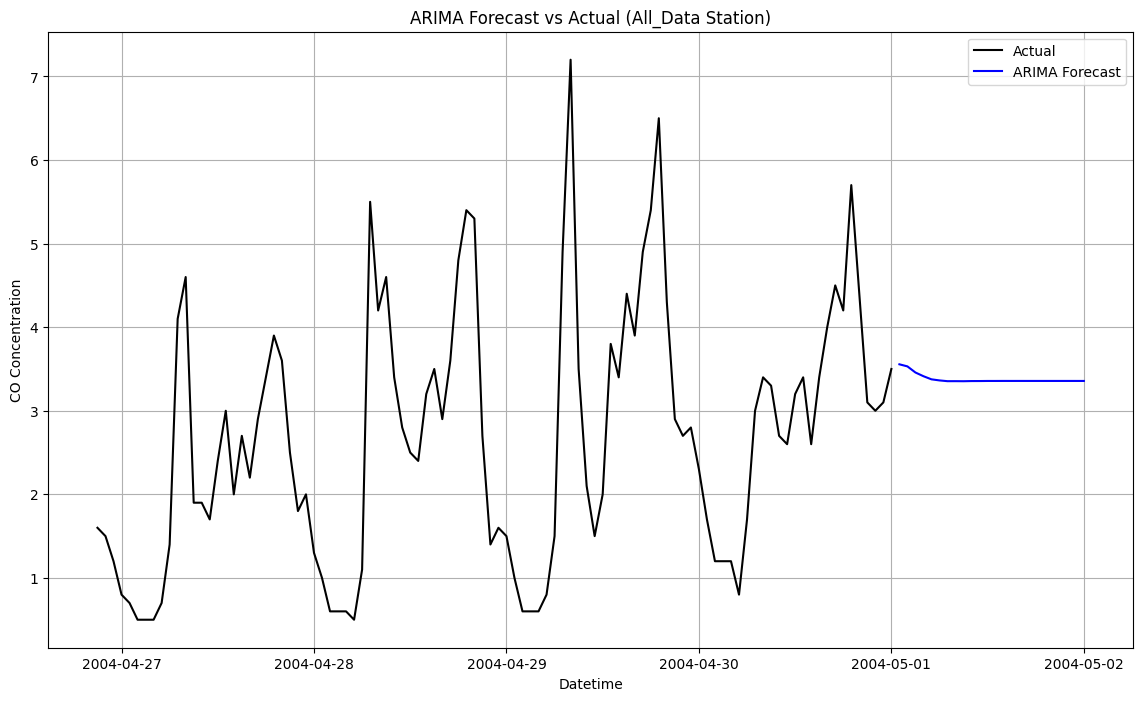

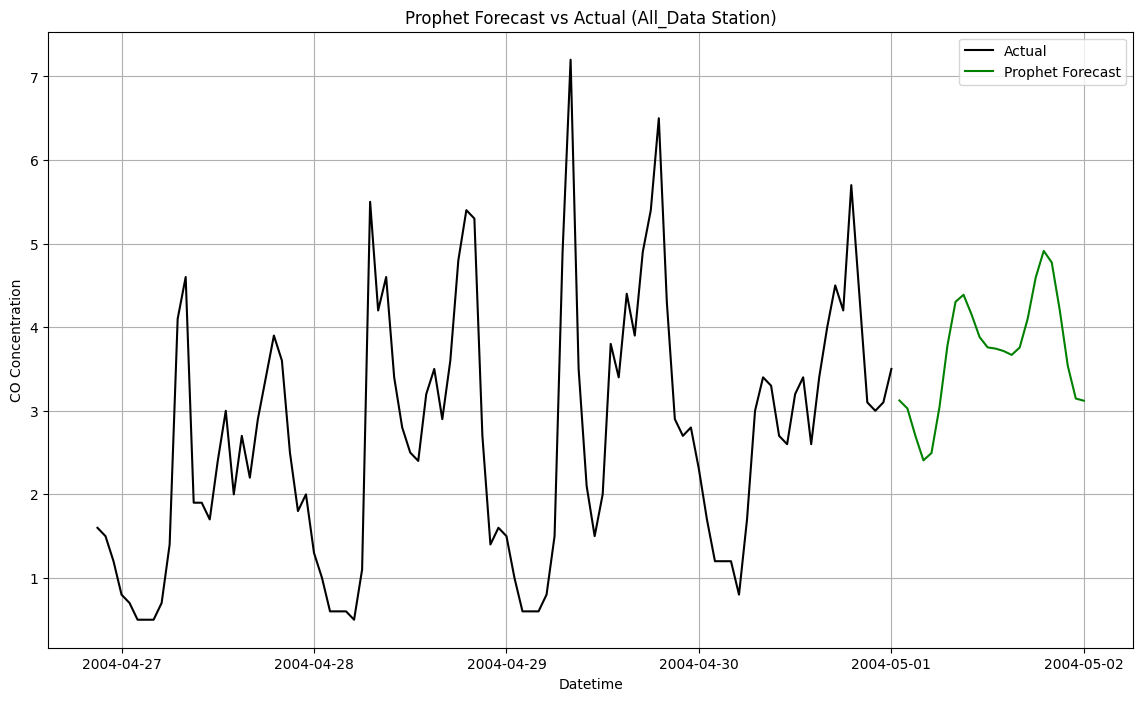

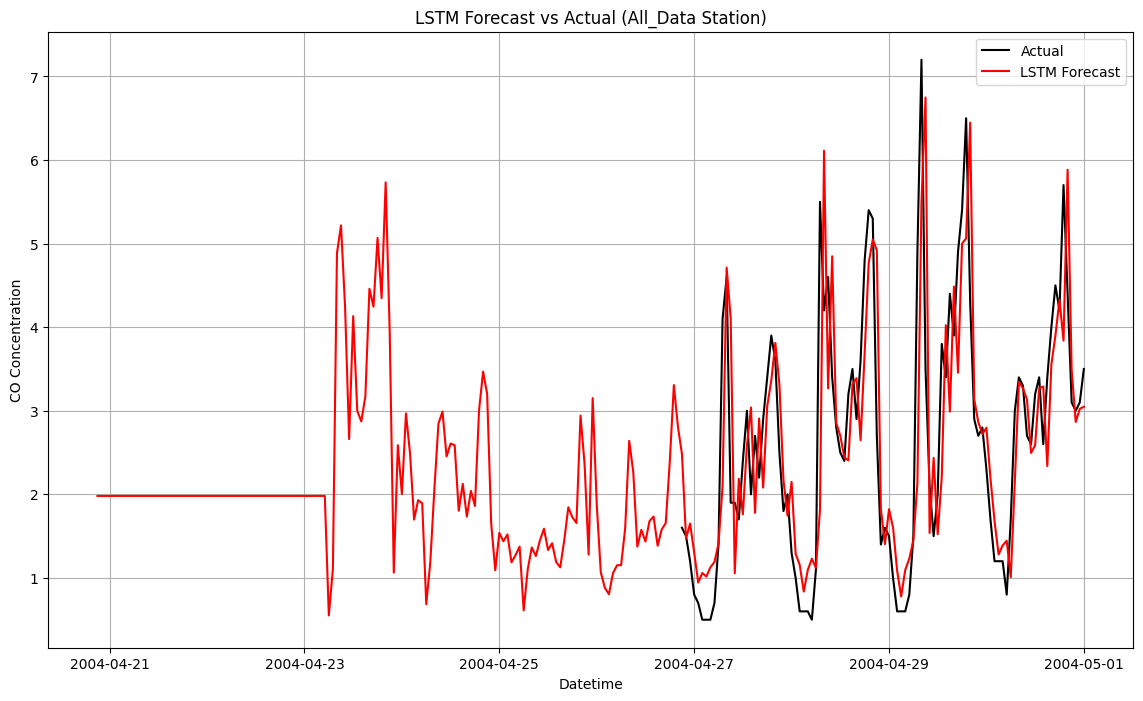

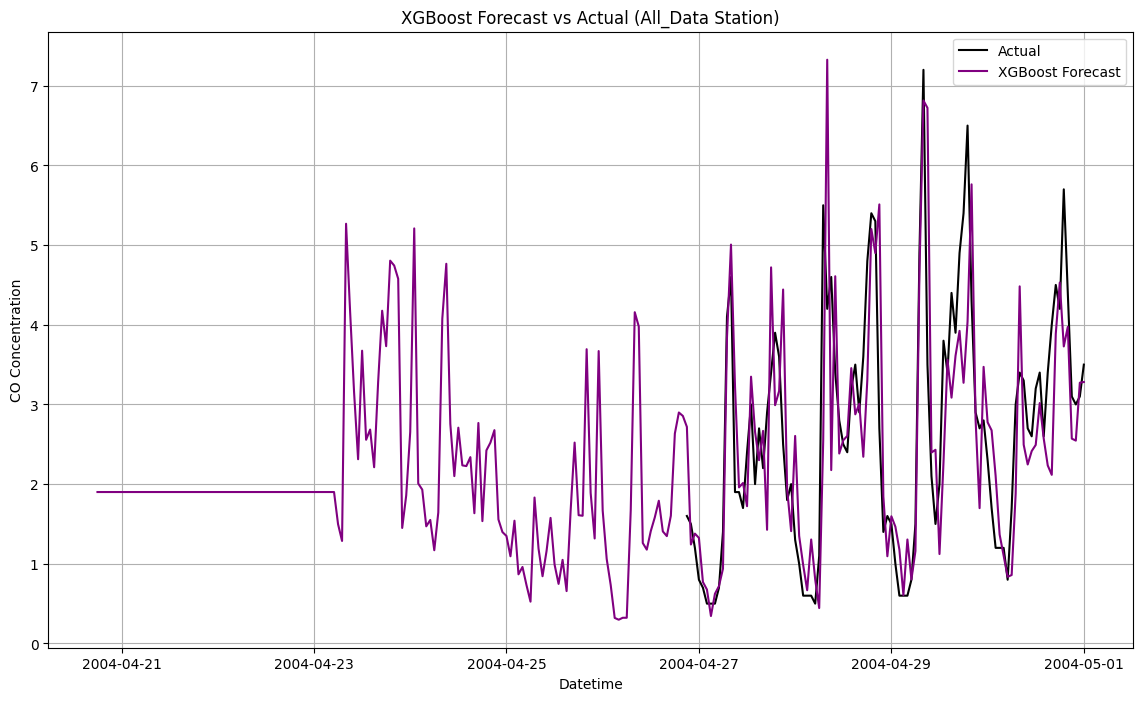

In [23]:
# Call the plotting function with the variables from the previous execution
plot_forecasts_comparison_all_data(series_hourly, arima_fit, prophet_forecast, lstm_pred_inv, y_test_inv, xgb_pred)

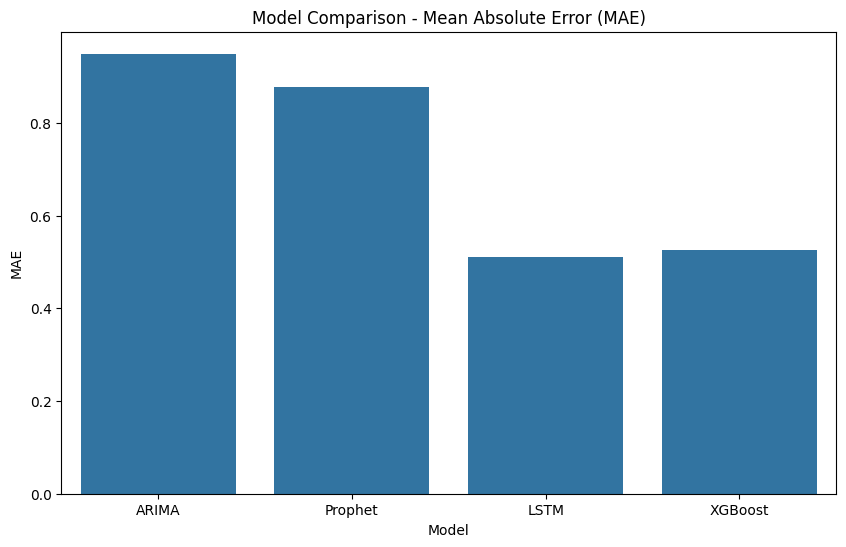

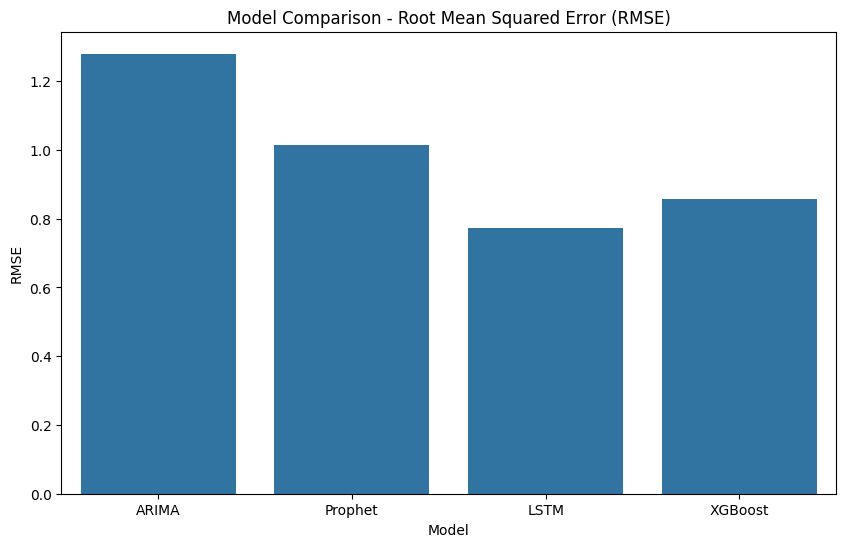

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot MAE
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('Model Comparison - Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('Model Comparison - Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()